# Importando Librerías

In [19]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json

# Definiendo funciones

In [20]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_gru():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NA\\ECG_'
    #importando patologias
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)
    
    #Uniendo canales
    ECG_Normal_Test=np.concatenate((ECG_Normal_Test[:,:,:,0],ECG_Normal_Test[:,:,:,1]),axis=1)
    ECG_SBR_Test=np.concatenate((ECG_SBR_Test[:,:,:,0],ECG_SBR_Test[:,:,:,1]),axis=1)
    ECG_AFIB_Test=np.concatenate((ECG_AFIB_Test[:,:,:,0],ECG_AFIB_Test[:,:,:,1]),axis=1)
    ECG_STE_Test=np.concatenate((ECG_STE_Test[:,:,:,0],ECG_STE_Test[:,:,:,1]),axis=1)
    ECG_STD_Test=np.concatenate((ECG_STD_Test[:,:,:,0],ECG_STD_Test[:,:,:,1]),axis=1)

    #Generando X_train
    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))
    
    X_test=np.moveaxis(X_test,1,2)   
    return X_test,Y_test
def load_data_gru():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NA\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)
    
    #Uniendo canales
    ECG_Normal_Train=np.concatenate((ECG_Normal_Train[:,:,:,0],ECG_Normal_Train[:,:,:,1]),axis=1)
    ECG_SBR_Train=np.concatenate((ECG_SBR_Train[:,:,:,0],ECG_SBR_Train[:,:,:,1]),axis=1)
    ECG_AFIB_Train=np.concatenate((ECG_AFIB_Train[:,:,:,0],ECG_AFIB_Train[:,:,:,1]),axis=1)
    ECG_STE_Train=np.concatenate((ECG_STE_Train[:,:,:,0],ECG_STE_Train[:,:,:,1]),axis=1)
    ECG_STD_Train=np.concatenate((ECG_STD_Train[:,:,:,0],ECG_STD_Train[:,:,:,1]),axis=1)
    
    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_gru()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    
    X_train=np.moveaxis(X_train,1,2)

    return X_train,Y_train,X_test,Y_test

In [3]:
# X_train,Y_train,X_test,Y_test=load_data_gru()
# X_train
# X_test

# print()
# print()
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

# Creando modelo para optimización con Optuna

In [4]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_GRU(trial):
    n_hidden=trial.suggest_categorical('n_hidden', [64,128,256])
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    strides_num=trial.suggest_int('strides',1,10)
    # kernel_sizes=trial.suggest_int('kernel_sizes',3,100)
    kernel_sizes=trial.suggest_categorical('kernel_sizes', [3,6,9,12,15,18,21,24,25])
    n_filters=trial.suggest_int('n_filters',16,256)
    # input_shape = (1, 51, 482)
    input_shape = (1, 241, 102)
    # Regularización L2
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=n_filters,kernel_size=kernel_sizes,strides=strides_num,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(n_hidden,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Flatten())
    # keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L2(1e-5))
    ModelGRU.add(keras.layers.Dense(n_hidden//2,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))
    ModelGRU.summary()
    
    return ModelGRU

def create_optimizer_GRU(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_GRU(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\NA\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_GRU=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    reset_keras()
    gc.collect()
    return history_GRU.history['val_accuracy'][-1]

def objective_GRU(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_gru()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_GRU(trial)
    optimizer=create_optimizer_GRU(trial)
    
    #Entrenando y validando
    loss=learn_GRU(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [5]:
study_GRU=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-09 17:42:51,848] A new study created in memory with name: no-name-5940cb75-64dc-44c7-8185-409280dcacd3


In [6]:
study_GRU.optimize(objective_GRU,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 129)           315921    
                                                                 
 batch_normalization (BatchN  (None, 28, 129)          516       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 129)           0         
                                                                 
 dropout (Dropout)           (None, 28, 129)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           99456     
            

[I 2023-04-09 17:43:50,181] Trial 0 finished with value: 0.20000000298023224 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 24, 'n_filters': 129, 'adam_learning_rate': 0.026226242594169648, 'batches': 88}. Best is trial 0 with value: 0.20000000298023224.


1484
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 139)           340411    
                                                                 
 batch_normalization (BatchN  (None, 73, 139)          556       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 139)           0         
                                                                 
 dropout (Dropout)           (None, 73, 139)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           103296    
       

[I 2023-04-09 17:45:59,115] Trial 1 finished with value: 0.16333332657814026 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.8, 'strides': 3, 'kernel_sizes': 24, 'n_filters': 139, 'adam_learning_rate': 2.5514895166229177e-05, 'batches': 166}. Best is trial 0 with value: 0.20000000298023224.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 164)           251084    
                                                                 
 batch_normalization (BatchN  (None, 46, 164)          656       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 164)           0         
                                                                 
 dropout (Dropout)           (None, 46, 164)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           112896    
            

[I 2023-04-09 17:47:52,950] Trial 2 finished with value: 0.25 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.6, 'strides': 5, 'kernel_sizes': 15, 'n_filters': 164, 'adam_learning_rate': 0.005177686341221124, 'batches': 87}. Best is trial 2 with value: 0.25.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 242)           74294     
                                                                 
 batch_normalization (BatchN  (None, 30, 242)          968       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 242)           0         
                                                                 
 dropout (Dropout)           (None, 30, 242)           0         
                                                                 
 gru (GRU)                   (None, 30, 128)           142848    
            

[I 2023-04-09 17:48:49,331] Trial 3 finished with value: 0.1899999976158142 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.8, 'strides': 8, 'kernel_sizes': 3, 'n_filters': 242, 'adam_learning_rate': 0.006803831146997117, 'batches': 200}. Best is trial 2 with value: 0.25.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 230)           352130    
                                                                 
 batch_normalization (BatchN  (None, 46, 230)          920       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 230)           0         
                                                                 
 dropout (Dropout)           (None, 46, 230)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           138240    
      

[I 2023-04-09 17:50:26,935] Trial 4 finished with value: 0.3933333456516266 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 15, 'n_filters': 230, 'adam_learning_rate': 0.0035296781870035802, 'batches': 129}. Best is trial 4 with value: 0.3933333456516266.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 109)           278059    
                                                                 
 batch_normalization (BatchN  (None, 28, 109)          436       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 109)           0         
                                                                 
 dropout (Dropout)           (None, 28, 109)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           91776     
      

[I 2023-04-09 17:52:09,786] Trial 5 finished with value: 0.75 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 25, 'n_filters': 109, 'adam_learning_rate': 4.4528272400375576e-05, 'batches': 69}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 95)            174515    
                                                                 
 batch_normalization (BatchN  (None, 25, 95)           380       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 95)            0         
                                                                 
 dropout (Dropout)           (None, 25, 95)            0         
                                                                 
 gru (GRU)                   (None, 25, 128)           86400     
      

[I 2023-04-09 17:53:19,384] Trial 6 finished with value: 0.6700000166893005 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.6, 'strides': 9, 'kernel_sizes': 18, 'n_filters': 95, 'adam_learning_rate': 0.0048475827389958676, 'batches': 122}. Best is trial 5 with value: 0.75.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 117, 36)           33084     
                                                                 
 batch_normalization (BatchN  (None, 117, 36)          144       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 117, 36)           0         
                                                                 
 dropout (Dropout)           (None, 117, 36)           0         
                                                                 
 gru (GRU)                   (None, 117, 128)          63744     
      

[I 2023-04-09 17:55:28,245] Trial 7 finished with value: 0.3766666650772095 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.7, 'strides': 2, 'kernel_sizes': 9, 'n_filters': 36, 'adam_learning_rate': 1.7461605519739538e-05, 'batches': 209}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 117)           286533    
                                                                 
 batch_normalization (BatchN  (None, 55, 117)          468       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 117)           0         
                                                                 
 dropout (Dropout)           (None, 55, 117)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           94848     
      

[I 2023-04-09 17:57:04,036] Trial 8 finished with value: 0.7433333396911621 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 117, 'adam_learning_rate': 0.00013648968908028903, 'batches': 241}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 116)           106604    
                                                                 
 batch_normalization (BatchN  (None, 78, 116)          464       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 78, 116)           0         
                                                                 
 dropout (Dropout)           (None, 78, 116)           0         
                                                                 
 gru (GRU)                   (None, 78, 128)           94464     
      

[I 2023-04-09 17:59:02,802] Trial 9 finished with value: 0.3499999940395355 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 9, 'n_filters': 116, 'adam_learning_rate': 1.2245678324351323e-05, 'batches': 170}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 22)            56122     
                                                                 
 batch_normalization (BatchN  (None, 22, 22)           88        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 22)            0         
                                                                 
 dropout (Dropout)           (None, 22, 22)            0         
                                                                 
 gru (GRU)                   (None, 22, 128)           58368     
      

[I 2023-04-09 18:00:31,526] Trial 10 finished with value: 0.5766666531562805 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 25, 'n_filters': 22, 'adam_learning_rate': 0.0003431048735970675, 'batches': 76}. Best is trial 5 with value: 0.75.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 78)            95550     
                                                                 
 batch_normalization (BatchN  (None, 33, 78)           312       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 78)            0         
                                                                 
 dropout (Dropout)           (None, 33, 78)            0         
                                                                 
 gru (GRU)                   (None, 33, 128)           79872     
            

[I 2023-04-09 18:01:30,242] Trial 11 finished with value: 0.7366666793823242 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 78, 'adam_learning_rate': 0.0001594122048852399, 'batches': 251}. Best is trial 5 with value: 0.75.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 178)           454078    
                                                                 
 batch_normalization (BatchN  (None, 37, 178)          712       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 37, 178)           0         
                                                                 
 dropout (Dropout)           (None, 37, 178)           0         
                                                                 
 gru (GRU)                   (None, 37, 128)           118272    
            

[I 2023-04-09 18:02:50,268] Trial 12 finished with value: 0.6899999976158142 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 6, 'kernel_sizes': 25, 'n_filters': 178, 'adam_learning_rate': 0.00011544781771462059, 'batches': 252}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 221, 66)           141438    
                                                                 
 batch_normalization (BatchN  (None, 221, 66)          264       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 221, 66)           0         
                                                                 
 dropout (Dropout)           (None, 221, 66)           0         
                                                                 
 gru (GRU)                   (None, 221, 128)          75264     
      

[I 2023-04-09 18:06:55,418] Trial 13 finished with value: 0.6433333158493042 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 1, 'kernel_sizes': 21, 'n_filters': 66, 'adam_learning_rate': 7.236680762476733e-05, 'batches': 214}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 194)           494894    
                                                                 
 batch_normalization (BatchN  (None, 55, 194)          776       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 194)           0         
                                                                 
 dropout (Dropout)           (None, 55, 194)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           124416    
      

[I 2023-04-09 18:09:00,782] Trial 14 finished with value: 0.6166666746139526 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.6, 'strides': 4, 'kernel_sizes': 25, 'n_filters': 194, 'adam_learning_rate': 0.0005981383918629581, 'batches': 126}. Best is trial 5 with value: 0.75.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 101)           61913     
                                                                 
 batch_normalization (BatchN  (None, 40, 101)          404       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 101)           0         
                                                                 
 dropout (Dropout)           (None, 40, 101)           0         
                                                                 
 gru (GRU)                   (None, 40, 128)           88704     
            

[I 2023-04-09 18:10:13,351] Trial 15 finished with value: 0.7066666483879089 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 6, 'n_filters': 101, 'adam_learning_rate': 5.863500836996098e-05, 'batches': 189}. Best is trial 5 with value: 0.75.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 149)           364901    
                                                                 
 batch_normalization (BatchN  (None, 22, 149)          596       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 149)           0         
                                                                 
 dropout (Dropout)           (None, 22, 149)           0         
                                                                 
 gru (GRU)                   (None, 22, 128)           107136    
            

[I 2023-04-09 18:11:11,592] Trial 16 finished with value: 0.653333306312561 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 24, 'n_filters': 149, 'adam_learning_rate': 0.00028816941571327344, 'batches': 235}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 34, 57)            34941     
                                                                 
 batch_normalization (BatchN  (None, 34, 57)           228       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 34, 57)            0         
                                                                 
 dropout (Dropout)           (None, 34, 57)            0         
                                                                 
 gru (GRU)                   (None, 34, 128)           71808     
      

[I 2023-04-09 18:12:23,405] Trial 17 finished with value: 0.4300000071525574 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.7, 'strides': 7, 'kernel_sizes': 6, 'n_filters': 57, 'adam_learning_rate': 0.0010913633540500184, 'batches': 141}. Best is trial 5 with value: 0.75.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 199)           61093     
                                                                 
 batch_normalization (BatchN  (None, 60, 199)          796       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 60, 199)           0         
                                                                 
 dropout (Dropout)           (None, 60, 199)           0         
                                                                 
 gru (GRU)                   (None, 60, 128)           126336    
      

[I 2023-04-09 18:14:44,430] Trial 18 finished with value: 0.7133333086967468 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 4, 'kernel_sizes': 3, 'n_filters': 199, 'adam_learning_rate': 3.998395682680896e-05, 'batches': 64}. Best is trial 5 with value: 0.75.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 108)           132300    
                                                                 
 batch_normalization (BatchN  (None, 29, 108)          432       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 108)           0         
                                                                 
 dropout (Dropout)           (None, 29, 108)           0         
                                                                 
 gru (GRU)                   (None, 29, 128)           91392     
            

[I 2023-04-09 18:16:09,016] Trial 19 finished with value: 0.8066666722297668 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 108, 'adam_learning_rate': 4.038677499769042e-05, 'batches': 104}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 80)            98000     
                                                                 
 batch_normalization (BatchN  (None, 29, 80)           320       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 80)            0         
                                                                 
 dropout (Dropout)           (None, 29, 80)            0         
                                                                 
 gru (GRU)                   (None, 29, 128)           80640     
            

[I 2023-04-09 18:17:33,951] Trial 20 finished with value: 0.36666667461395264 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 80, 'adam_learning_rate': 1.0452036555701402e-05, 'batches': 104}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 111)           135975    
                                                                 
 batch_normalization (BatchN  (None, 26, 111)          444       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 111)           0         
                                                                 
 dropout (Dropout)           (None, 26, 111)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           92544     
            

[I 2023-04-09 18:18:56,264] Trial 21 finished with value: 0.6600000262260437 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 12, 'n_filters': 111, 'adam_learning_rate': 3.836723318650807e-05, 'batches': 104}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 129)           236973    
                                                                 
 batch_normalization (BatchN  (None, 32, 129)          516       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 129)           0         
                                                                 
 dropout (Dropout)           (None, 32, 129)           0         
                                                                 
 gru (GRU)                   (None, 32, 128)           99456     
            

[I 2023-04-09 18:20:31,234] Trial 22 finished with value: 0.6833333373069763 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 18, 'n_filters': 129, 'adam_learning_rate': 6.889199752944453e-05, 'batches': 105}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 154)           330022    
                                                                 
 batch_normalization (BatchN  (None, 25, 154)          616       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 154)           0         
                                                                 
 dropout (Dropout)           (None, 25, 154)           0         
                                                                 
 gru (GRU)                   (None, 25, 128)           109056    
            

[I 2023-04-09 18:21:56,675] Trial 23 finished with value: 0.6266666650772095 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 9, 'kernel_sizes': 21, 'n_filters': 154, 'adam_learning_rate': 2.698244500988172e-05, 'batches': 147}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 91)            222859    
                                                                 
 batch_normalization (BatchN  (None, 55, 91)           364       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 91)            0         
                                                                 
 dropout (Dropout)           (None, 55, 91)            0         
                                                                 
 gru (GRU)                   (None, 55, 128)           84864     
            

[I 2023-04-09 18:24:12,492] Trial 24 finished with value: 0.7066666483879089 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 91, 'adam_learning_rate': 0.00015216706695526803, 'batches': 64}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 52)            132652    
                                                                 
 batch_normalization (BatchN  (None, 37, 52)           208       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 37, 52)            0         
                                                                 
 dropout (Dropout)           (None, 37, 52)            0         
                                                                 
 gru (GRU)                   (None, 37, 128)           69888     
            

[I 2023-04-09 18:25:24,604] Trial 25 finished with value: 0.6233333349227905 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 6, 'kernel_sizes': 25, 'n_filters': 52, 'adam_learning_rate': 2.4216017414400227e-05, 'batches': 185}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 118)           144550    
                                                                 
 batch_normalization (BatchN  (None, 33, 118)          472       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 118)           0         
                                                                 
 dropout (Dropout)           (None, 33, 118)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           95232     
            

[I 2023-04-09 18:27:05,519] Trial 26 finished with value: 0.7333333492279053 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 118, 'adam_learning_rate': 8.148359677505628e-05, 'batches': 88}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 169)           413881    
                                                                 
 batch_normalization (BatchN  (None, 44, 169)          676       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 169)           0         
                                                                 
 dropout (Dropout)           (None, 44, 169)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           114816    
            

[I 2023-04-09 18:28:40,465] Trial 27 finished with value: 0.7900000214576721 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 5, 'kernel_sizes': 24, 'n_filters': 169, 'adam_learning_rate': 0.00020051093927632248, 'batches': 225}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 216)           551016    
                                                                 
 batch_normalization (BatchN  (None, 28, 216)          864       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 216)           0         
                                                                 
 dropout (Dropout)           (None, 28, 216)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           132864    
            

[I 2023-04-09 18:29:55,154] Trial 28 finished with value: 0.6566666960716248 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.7, 'strides': 8, 'kernel_sizes': 25, 'n_filters': 216, 'adam_learning_rate': 5.0195349647507246e-05, 'batches': 222}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 173)           211925    
                                                                 
 batch_normalization (BatchN  (None, 46, 173)          692       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 173)           0         
                                                                 
 dropout (Dropout)           (None, 46, 173)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           116352    
            

[I 2023-04-09 18:31:30,209] Trial 29 finished with value: 0.20000000298023224 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 5, 'kernel_sizes': 12, 'n_filters': 173, 'adam_learning_rate': 0.055352966180820966, 'batches': 87}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 142)           347758    
                                                                 
 batch_normalization (BatchN  (None, 25, 142)          568       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 25, 142)           0         
                                                                 
 dropout (Dropout)           (None, 25, 142)           0         
                                                                 
 gru (GRU)                   (None, 25, 128)           104448    
            

[I 2023-04-09 18:32:41,233] Trial 30 finished with value: 0.5566666722297668 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 9, 'kernel_sizes': 24, 'n_filters': 142, 'adam_learning_rate': 1.628694467139077e-05, 'batches': 154}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 126)           308574    
                                                                 
 batch_normalization (BatchN  (None, 55, 126)          504       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 126)           0         
                                                                 
 dropout (Dropout)           (None, 55, 126)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           98304     
            

[I 2023-04-09 18:34:11,301] Trial 31 finished with value: 0.7633333206176758 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 126, 'adam_learning_rate': 0.00020346953070662696, 'batches': 232}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 138)           337962    
                                                                 
 batch_normalization (BatchN  (None, 73, 138)          552       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 73, 138)           0         
                                                                 
 dropout (Dropout)           (None, 73, 138)           0         
                                                                 
 gru (GRU)                   (None, 73, 128)           102912    
            

[I 2023-04-09 18:36:20,278] Trial 32 finished with value: 0.6766666769981384 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 3, 'kernel_sizes': 24, 'n_filters': 138, 'adam_learning_rate': 0.00024757941839258956, 'batches': 234}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 131)           320819    
                                                                 
 batch_normalization (BatchN  (None, 44, 131)          524       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 131)           0         
                                                                 
 dropout (Dropout)           (None, 44, 131)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           100224    
            

[I 2023-04-09 18:37:53,509] Trial 33 finished with value: 0.7133333086967468 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 5, 'kernel_sizes': 24, 'n_filters': 131, 'adam_learning_rate': 3.4660089419816424e-05, 'batches': 178}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 163)           249553    
                                                                 
 batch_normalization (BatchN  (None, 38, 163)          652       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 163)           0         
                                                                 
 dropout (Dropout)           (None, 38, 163)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           112512    
            

[I 2023-04-09 18:39:11,465] Trial 34 finished with value: 0.7400000095367432 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 15, 'n_filters': 163, 'adam_learning_rate': 9.073826518206048e-05, 'batches': 224}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 109, 186)          455514    
                                                                 
 batch_normalization (BatchN  (None, 109, 186)         744       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 109, 186)          0         
                                                                 
 dropout (Dropout)           (None, 109, 186)          0         
                                                                 
 gru (GRU)                   (None, 109, 128)          121344    
            

[I 2023-04-09 18:42:16,715] Trial 35 finished with value: 0.5866666436195374 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.6, 'strides': 2, 'kernel_sizes': 24, 'n_filters': 186, 'adam_learning_rate': 0.0005160375314518644, 'batches': 193}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 80, 99)            30393     
                                                                 
 batch_normalization (BatchN  (None, 80, 99)           396       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 99)            0         
                                                                 
 dropout (Dropout)           (None, 80, 99)            0         
                                                                 
 gru (GRU)                   (None, 80, 128)           87936     
            

[I 2023-04-09 18:44:00,762] Trial 36 finished with value: 0.38333332538604736 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.8, 'strides': 3, 'kernel_sizes': 3, 'n_filters': 99, 'adam_learning_rate': 0.00019626159188317218, 'batches': 205}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 156)           286572    
                                                                 
 batch_normalization (BatchN  (None, 45, 156)          624       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 45, 156)           0         
                                                                 
 dropout (Dropout)           (None, 45, 156)           0         
                                                                 
 gru (GRU)                   (None, 45, 128)           109824    
            

[I 2023-04-09 18:45:43,304] Trial 37 finished with value: 0.6166666746139526 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.5, 'strides': 5, 'kernel_sizes': 18, 'n_filters': 156, 'adam_learning_rate': 9.614088469907181e-05, 'batches': 117}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           117632    
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 128)           0         
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 gru (GRU)                   (None, 30, 128)           99072     
            

[I 2023-04-09 18:47:25,466] Trial 38 finished with value: 0.6899999976158142 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 9, 'n_filters': 128, 'adam_learning_rate': 2.317474478575229e-05, 'batches': 77}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 81)            124011    
                                                                 
 batch_normalization (BatchN  (None, 33, 81)           324       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 81)            0         
                                                                 
 dropout (Dropout)           (None, 33, 81)            0         
                                                                 
 gru (GRU)                   (None, 33, 128)           81024     
            

[I 2023-04-09 18:48:46,384] Trial 39 finished with value: 0.47333332896232605 and parameters: {'n_hidden': 64, 'drop_path_rate': 0.7, 'strides': 7, 'kernel_sizes': 15, 'n_filters': 81, 'adam_learning_rate': 5.118016839464992e-05, 'batches': 137}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 109, 211)          516739    
                                                                 
 batch_normalization (BatchN  (None, 109, 211)         844       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 109, 211)          0         
                                                                 
 dropout (Dropout)           (None, 109, 211)          0         
                                                                 
 gru (GRU)                   (None, 109, 128)          130944    
            

[I 2023-04-09 18:52:04,295] Trial 40 finished with value: 0.6233333349227905 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 2, 'kernel_sizes': 24, 'n_filters': 211, 'adam_learning_rate': 0.000114712820498894, 'batches': 165}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 113)           276737    
                                                                 
 batch_normalization (BatchN  (None, 55, 113)          452       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 113)           0         
                                                                 
 dropout (Dropout)           (None, 55, 113)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           93312     
            

[I 2023-04-09 18:53:44,744] Trial 41 finished with value: 0.6933333277702332 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 113, 'adam_learning_rate': 0.0001713038623818347, 'batches': 240}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 106)           259594    
                                                                 
 batch_normalization (BatchN  (None, 55, 106)          424       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 106)           0         
                                                                 
 dropout (Dropout)           (None, 55, 106)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           90624     
            

[I 2023-04-09 18:55:25,514] Trial 42 finished with value: 0.7400000095367432 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 106, 'adam_learning_rate': 0.0001308820259282015, 'batches': 243}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 119)           291431    
                                                                 
 batch_normalization (BatchN  (None, 44, 119)          476       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 119)           0         
                                                                 
 dropout (Dropout)           (None, 44, 119)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           95616     
            

[I 2023-04-09 18:56:51,279] Trial 43 finished with value: 0.79666668176651 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 5, 'kernel_sizes': 24, 'n_filters': 119, 'adam_learning_rate': 0.0003244475743633272, 'batches': 222}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 256)           548608    
                                                                 
 batch_normalization (BatchN  (None, 45, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 45, 256)           0         
                                                                 
 dropout (Dropout)           (None, 45, 256)           0         
                                                                 
 gru (GRU)                   (None, 45, 128)           148224    
            

[I 2023-04-09 18:58:30,200] Trial 44 finished with value: 0.6966666579246521 and parameters: {'n_hidden': 128, 'drop_path_rate': 0.5, 'strides': 5, 'kernel_sizes': 21, 'n_filters': 256, 'adam_learning_rate': 0.0003701894548885798, 'batches': 219}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 124)           316324    
                                                                 
 batch_normalization (BatchN  (None, 37, 124)          496       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 37, 124)           0         
                                                                 
 dropout (Dropout)           (None, 37, 124)           0         
                                                                 
 gru (GRU)                   (None, 37, 128)           97536     
            

[I 2023-04-09 18:59:47,009] Trial 45 finished with value: 0.800000011920929 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 25, 'n_filters': 124, 'adam_learning_rate': 0.00021579581276803488, 'batches': 230}. Best is trial 19 with value: 0.8066666722297668.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 169)           413881    
                                                                 
 batch_normalization (BatchN  (None, 44, 169)          676       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 169)           0         
                                                                 
 dropout (Dropout)           (None, 44, 169)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           114816    
      

[I 2023-04-09 19:01:21,999] Trial 46 finished with value: 0.6133333444595337 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 24, 'n_filters': 169, 'adam_learning_rate': 0.0008300036084893076, 'batches': 228}. Best is trial 19 with value: 0.8066666722297668.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 124)           76012     
                                                                 
 batch_normalization (BatchN  (None, 40, 124)          496       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 124)           0         
                                                                 
 dropout (Dropout)           (None, 40, 124)           0         
                                                                 
 gru (GRU)                   (None, 40, 128)           97536     
      

[I 2023-04-09 19:02:35,256] Trial 47 finished with value: 0.6100000143051147 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 6, 'n_filters': 124, 'adam_learning_rate': 0.0013620449332408008, 'batches': 208}. Best is trial 19 with value: 0.8066666722297668.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 143)           364793    
                                                                 
 batch_normalization (BatchN  (None, 37, 143)          572       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 37, 143)           0         
                                                                 
 dropout (Dropout)           (None, 37, 143)           0         
                                                                 
 gru (GRU)                   (None, 37, 128)           104832    
      

[I 2023-04-09 19:03:57,105] Trial 48 finished with value: 0.6000000238418579 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.5, 'strides': 6, 'kernel_sizes': 25, 'n_filters': 143, 'adam_learning_rate': 0.00025107918135131035, 'batches': 256}. Best is trial 19 with value: 0.8066666722297668.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 159)           146121    
                                                                 
 batch_normalization (BatchN  (None, 78, 159)          636       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 78, 159)           0         
                                                                 
 dropout (Dropout)           (None, 78, 159)           0         
                                                                 
 gru (GRU)                   (None, 78, 128)           110976    
            

[I 2023-04-09 19:06:07,486] Trial 49 finished with value: 0.27000001072883606 and parameters: {'n_hidden': 256, 'drop_path_rate': 0.6, 'strides': 3, 'kernel_sizes': 9, 'n_filters': 159, 'adam_learning_rate': 0.0003948597396033869, 'batches': 202}. Best is trial 19 with value: 0.8066666722297668.


# Graficas obetenidas de la optimización

In [7]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_GRU)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_contour(study_GRU, params=["adam_learning_rate", "drop_path_rate"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [9]:
fig = optuna.visualization.plot_optimization_history(study_GRU,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [14]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_GRU.trials))
print("Number of BEST trials: ", study_GRU.best_trial.number)
print("Best trial:")
trial = study_GRU.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 9' con valor 0.8166666626930237

Number of finished trials:  50
Number of BEST trials:  19
Best trial:
  Value:  0.8066666722297668
  Params: 
    n_hidden: 64
    drop_path_rate: 0.5
    strides: 8
    kernel_sizes: 12
    n_filters: 108
    adam_learning_rate: 4.038677499769042e-05
    batches: 104


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 1s 8ms/step
[[3.1973475e-08 2.8953475e-06 9.9998736e-01 3.1260527e-06 6.5706936e-06]
 [9.5605582e-01 3.1286363e-06 9.1693373e-06 6.2765717e-04 4.3304194e-02]
 [7.2594923e-07 8.7149641e-07 9.9999273e-01 1.0494314e-06 4.5901147e-06]
 ...
 [5.1289160e-02 4.3978728e-03 7.0139504e-06 6.7003556e-03 9.3760556e-01]
 [2.5840532e-03 3.1373813e-03 7.0429860e-06 1.4640251e-02 9.7963125e-01]
 [4.4239938e-02 1.1570154e-04 1.4952502e-04 1.7013474e-01 7.8536010e-01]]
Normalized confusion matrix
[[0.83 0.   0.13 0.03 0.  ]
 [0.   0.93 0.   0.03 0.03]
 [0.   0.   0.97 0.03 0.  ]
 [0.27 0.   0.   0.4  0.33]
 [0.08 0.02 0.   0.   0.9 ]]


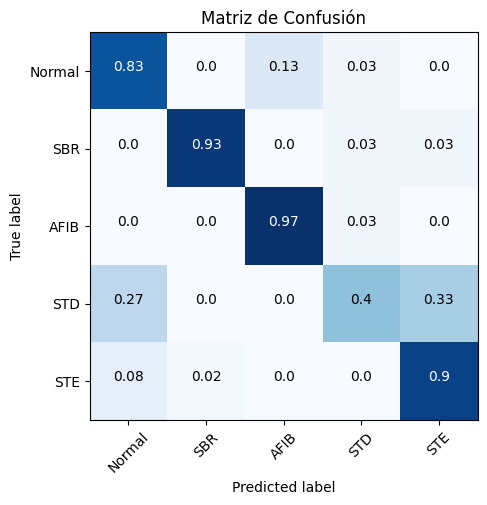

In [24]:

# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\NA\\mejor_modelo_trial'
modelo='8'
Best_Model_GRU = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_GRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NA\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_NA.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [17]:
#{'drop_path_rate': 0.7, 'strides': 8, 'kernel_sizes': 12, 'n_filters': 161, 'adam_learning_rate': 8.744649804740428e-05, 'batches': 97}
def create_model_gru():
    input_shape = (1, 241, 102)
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=108,kernel_size=12,strides=8,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(0.5))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.5))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.5))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(0.5))
    ModelGRU.add(keras.layers.Flatten())
    ModelGRU.add(keras.layers.Dense(64,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(0.5))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))  
    ModelGRU.summary()
    
    return ModelGRU


In [18]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_gru()
data_val=np.moveaxis(data_val,1,-2)

# Entrenando y guardando el modelo
Best_Hiper_ModelGRU=create_model_gru()
opt = optimizers.Adam(learning_rate=4.038677499769042e-05)
Best_Hiper_ModelGRU.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\NA\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_RNN_NA.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelGRU.fit(data_test,labels_test_OHE,verbose=1,epochs=50,batch_size=104,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

5149
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 108)           132300    
                                                                 
 batch_normalization (BatchN  (None, 29, 108)          432       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 108)           0         
                                                                 
 dropout (Dropout)           (None, 29, 108)           0         
                                                                 
 gru (GRU)                   (None, 29, 128)           91392     
       

# Graficas modelo con los mejores hiperparámetros

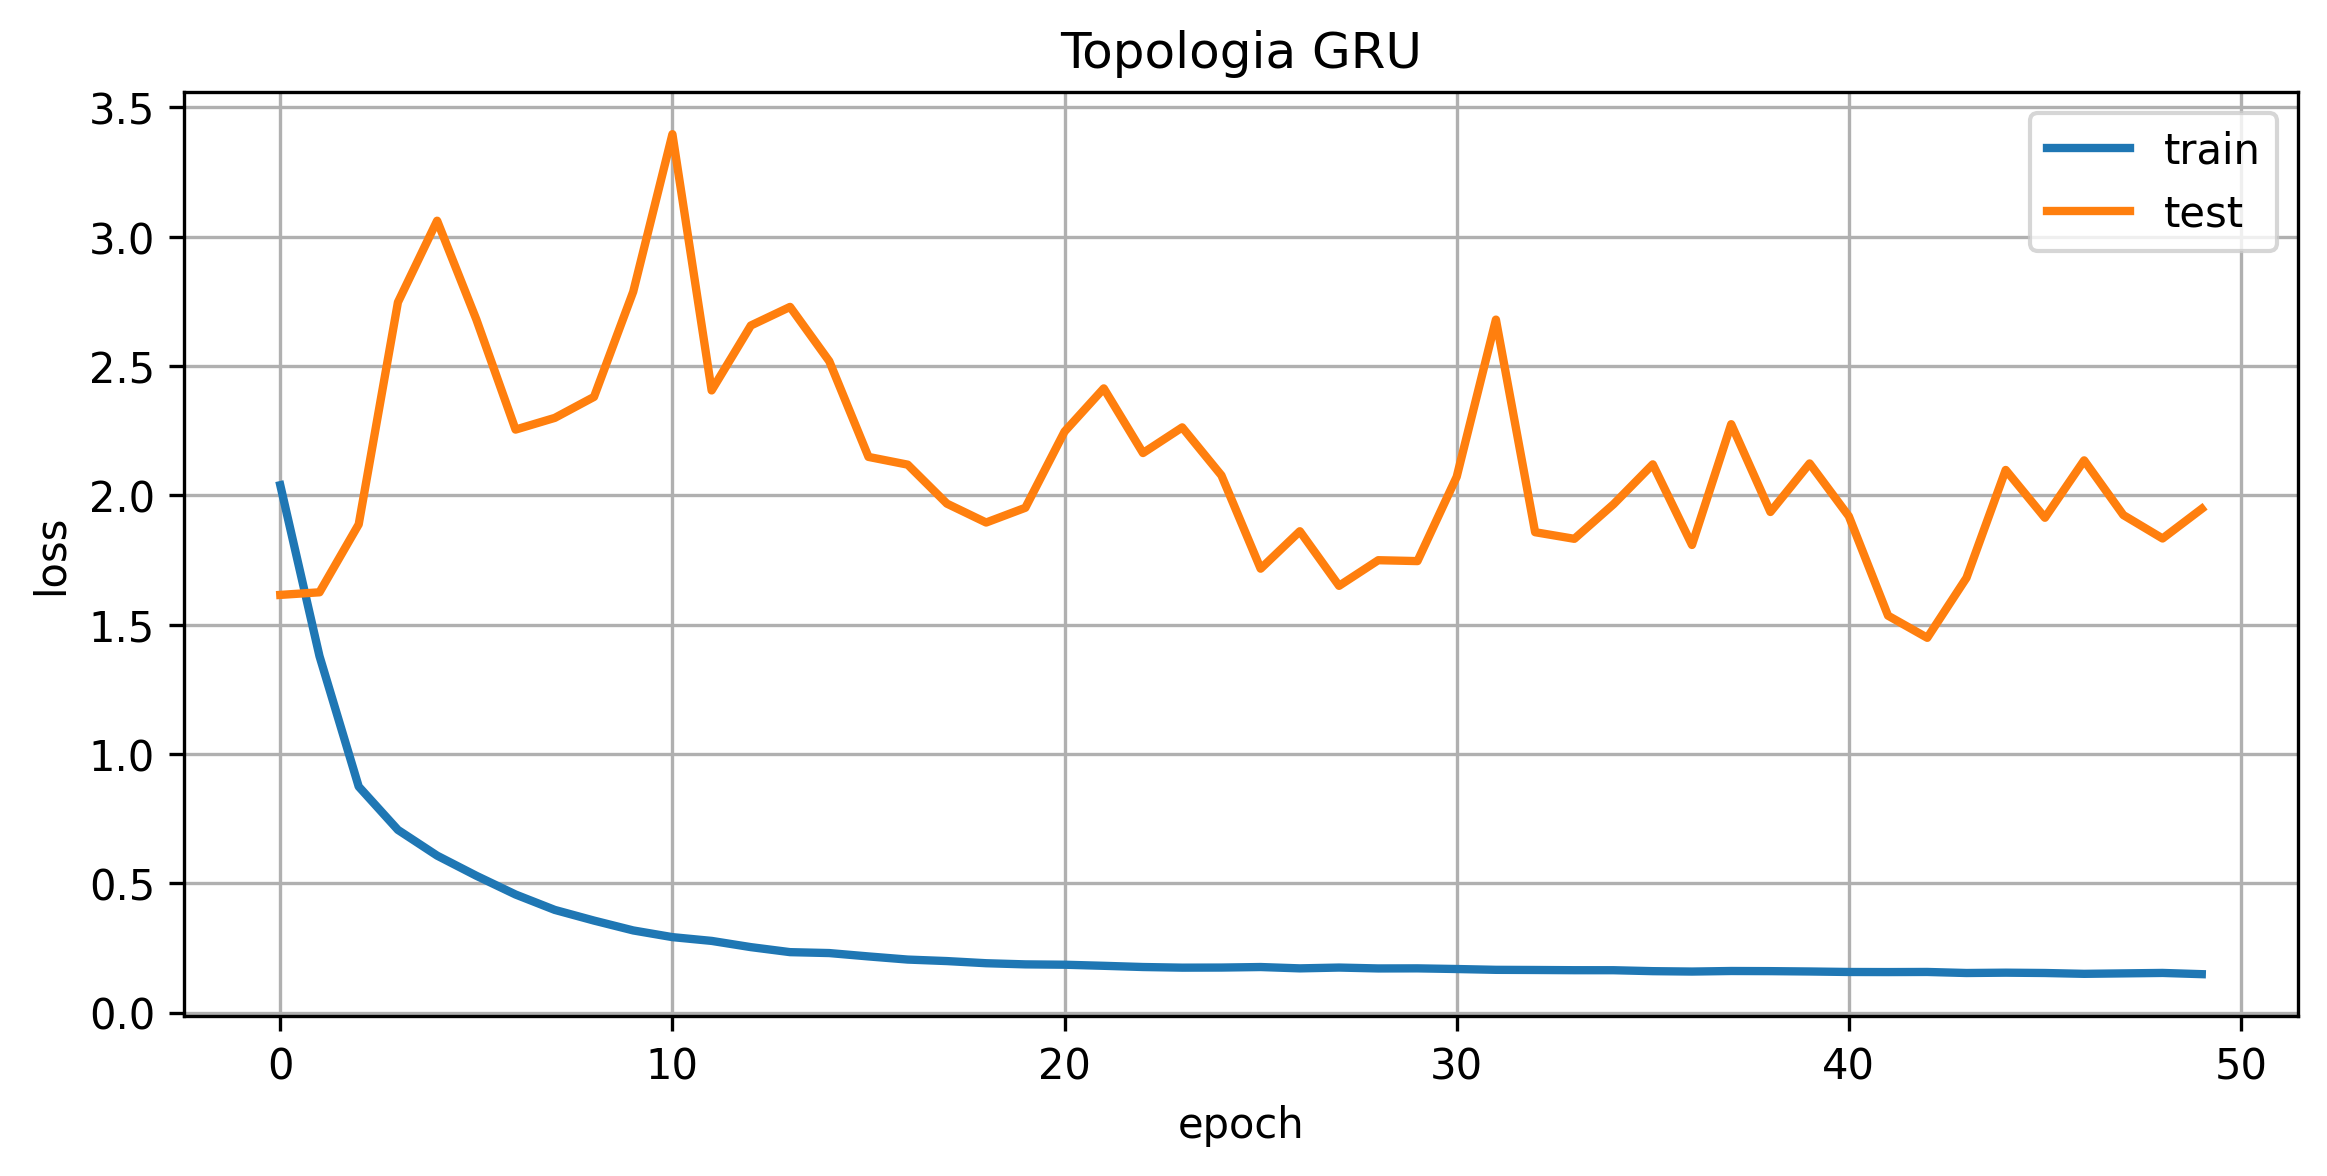

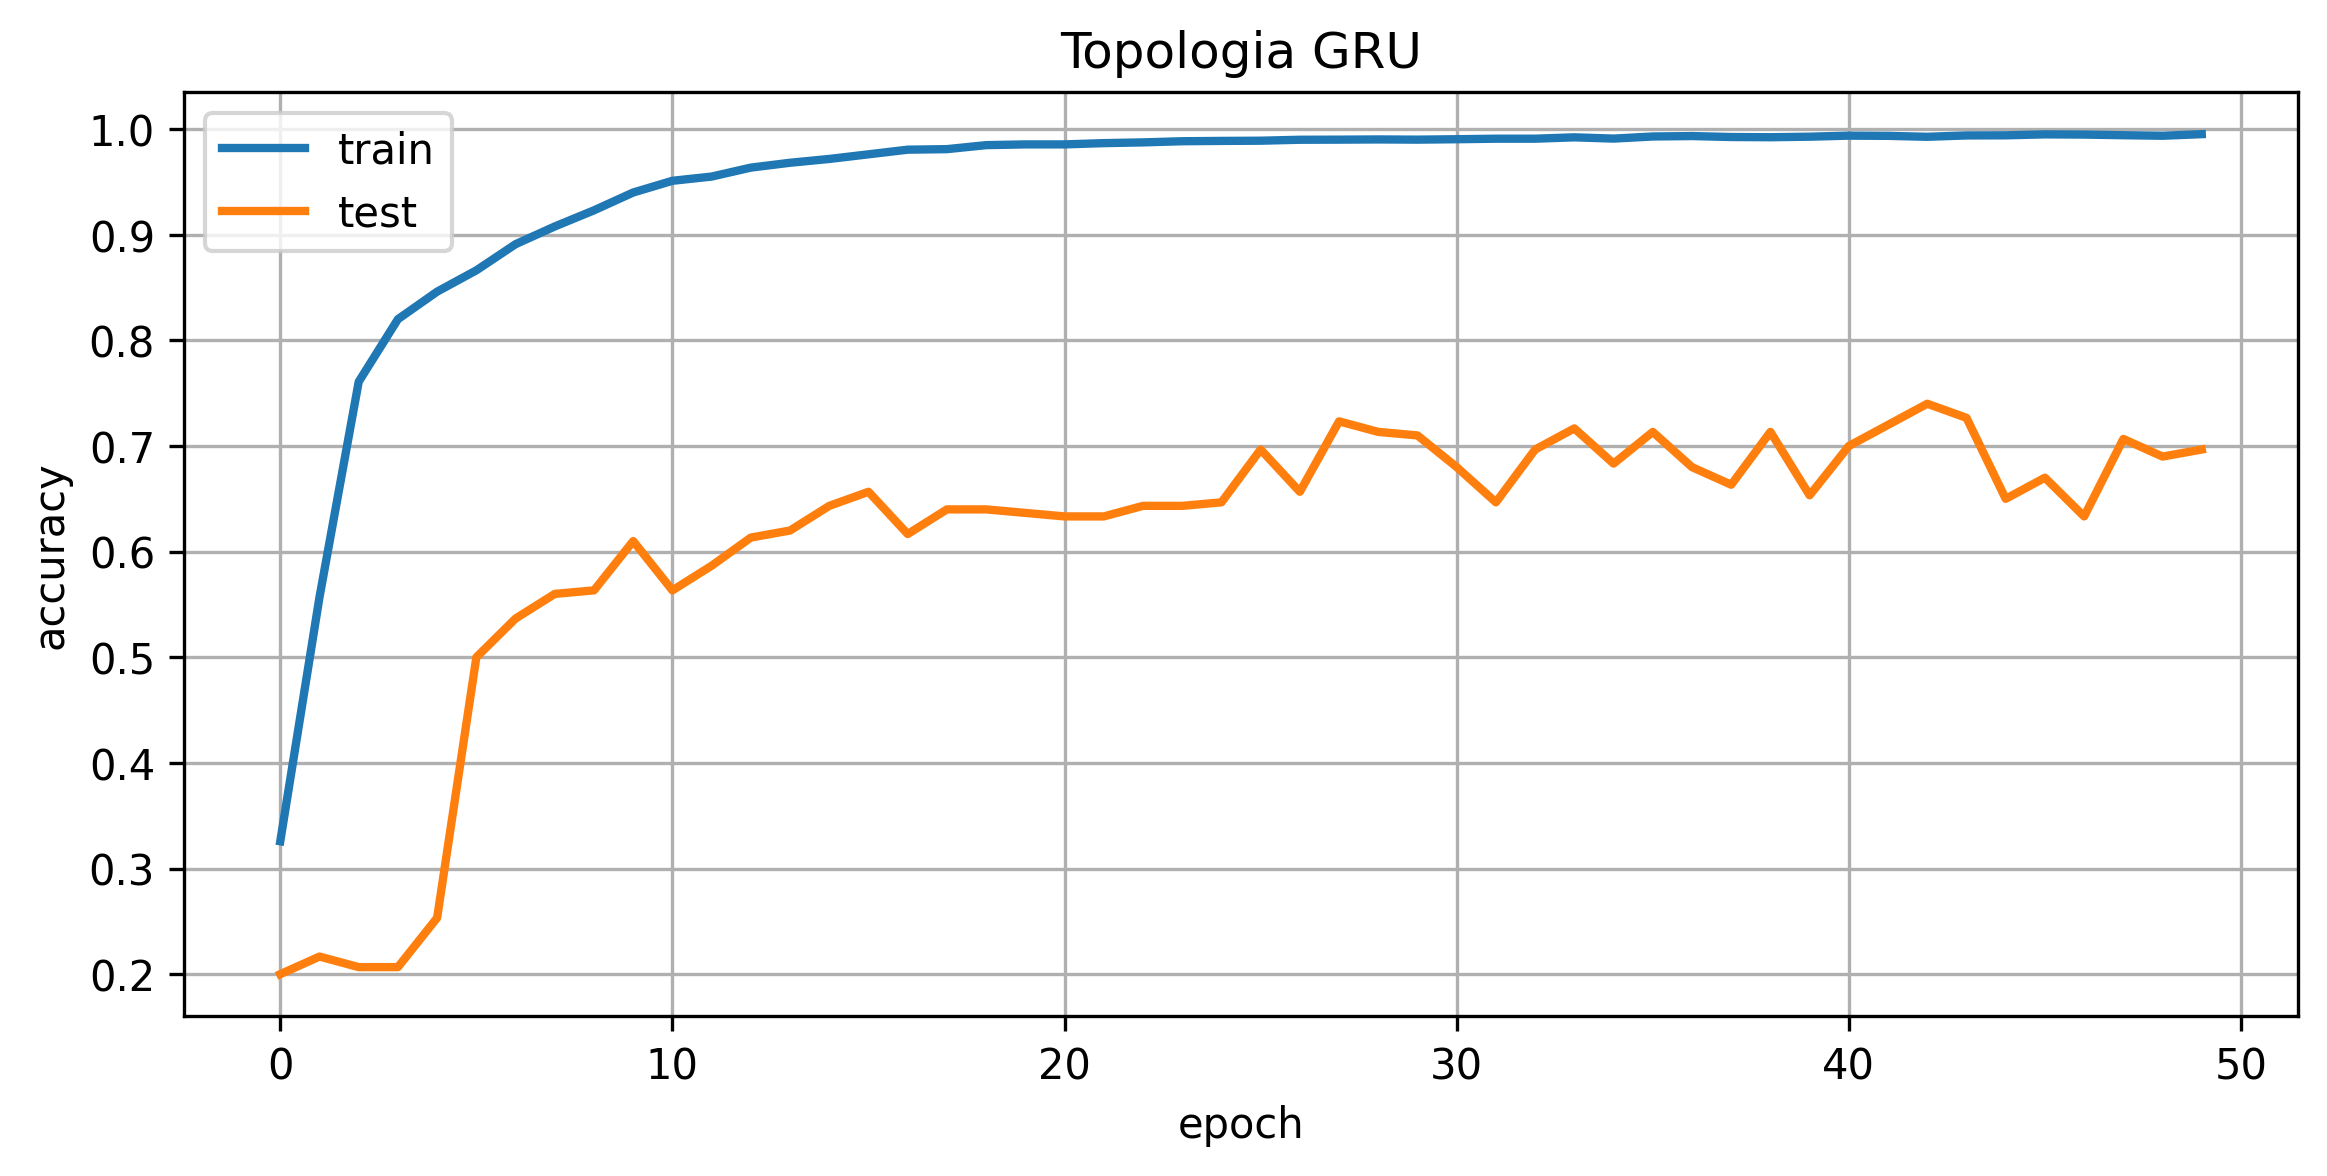

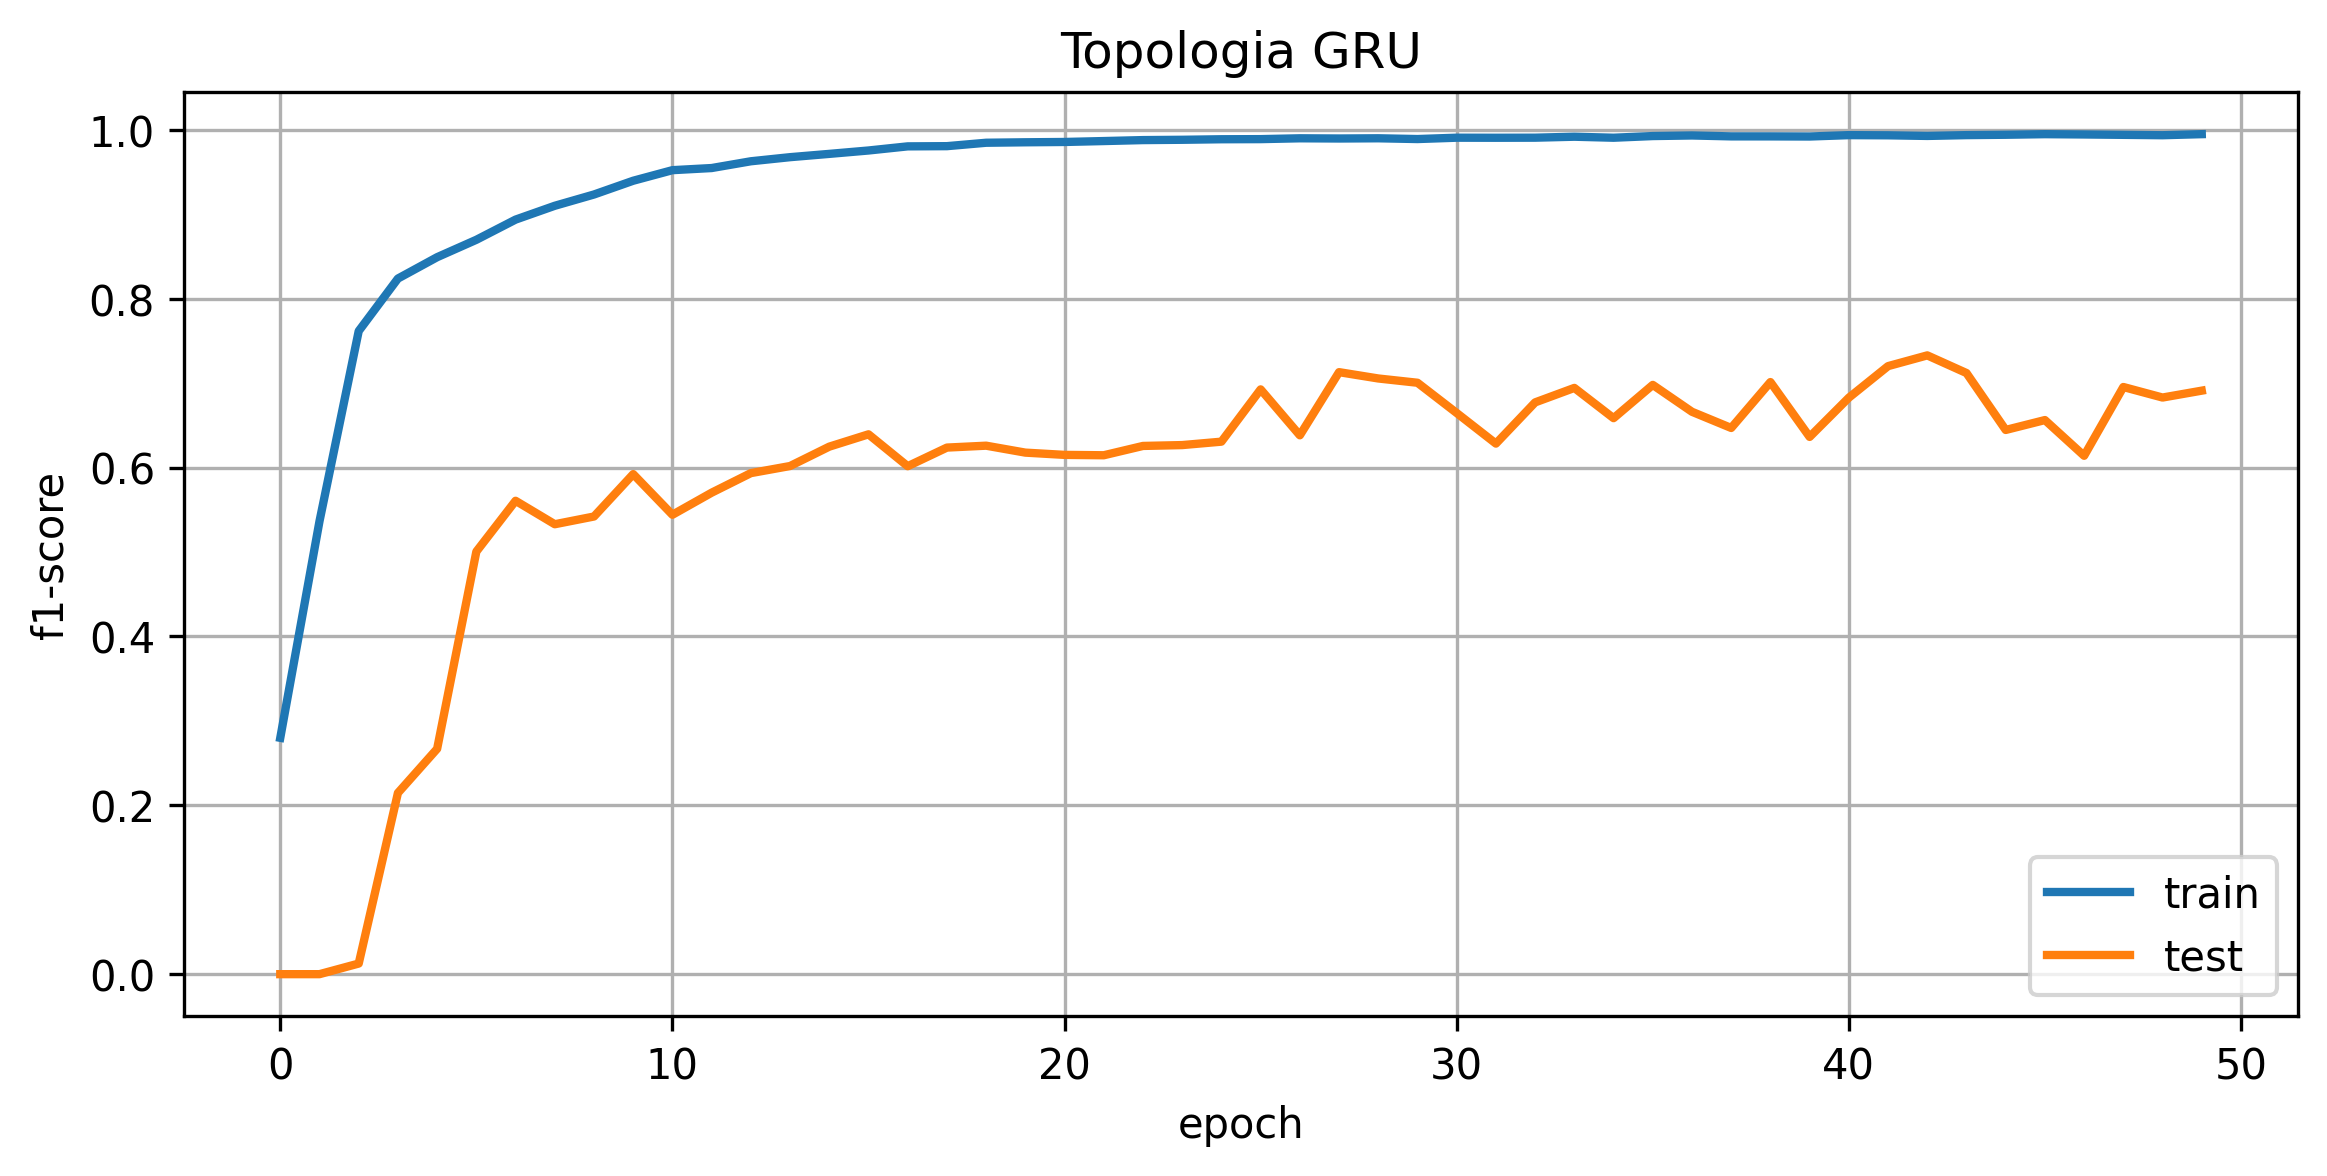

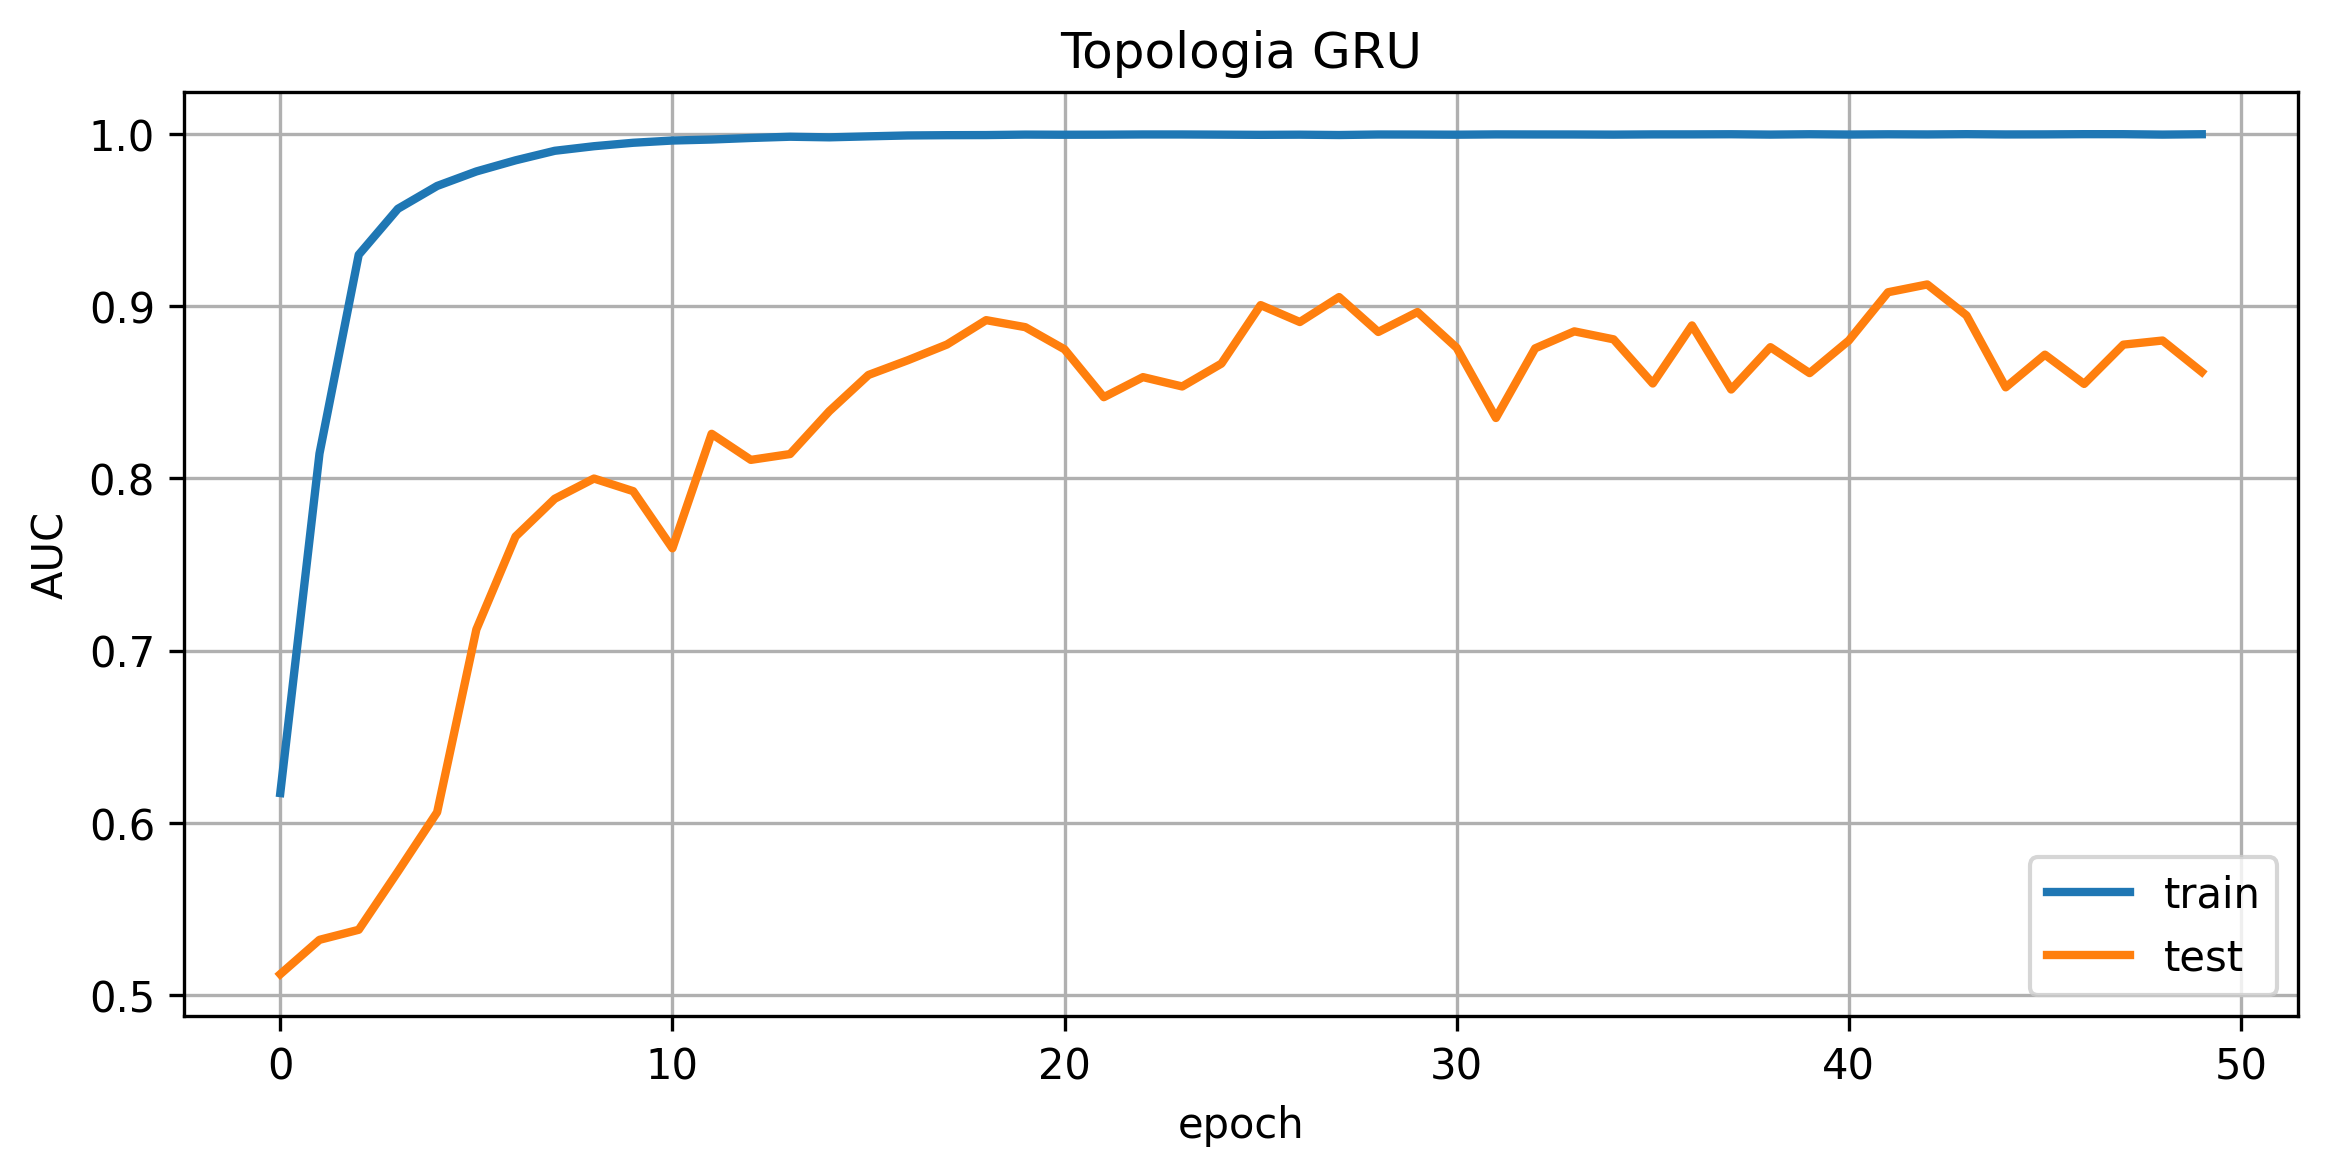

In [23]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['auc'], linewidth=2,)
plt.plot(history.history['val_auc'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 10ms/step
[[7.5401318e-01 1.0420644e-04 1.8160116e-04 1.2846008e-02 2.3285499e-01]
 [3.7457669e-04 3.7018784e-05 5.1161839e-04 9.9858320e-01 4.9351220e-04]
 [9.0041071e-01 3.4821584e-05 1.4508509e-02 8.3771415e-02 1.2746375e-03]
 ...
 [1.7517561e-04 8.6739972e-05 2.7256590e-05 9.9928266e-01 4.2813193e-04]
 [2.1117425e-05 1.0229718e-04 1.9747569e-05 9.9901938e-01 8.3744520e-04]
 [1.8666999e-05 1.2708892e-04 2.2435095e-05 9.9799877e-01 1.8330036e-03]]
Normalized confusion matrix
[[0.38 0.   0.17 0.22 0.23]
 [0.   0.98 0.   0.02 0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.03 0.72 0.25]
 [0.13 0.07 0.   0.43 0.37]]


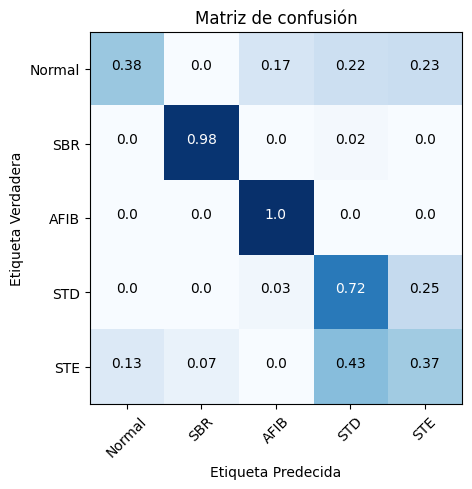

In [20]:
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)
y_prediction = Best_Hiper_ModelGRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NA\\MatrizDatosTestModeloEntrenadoNA.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 6ms/step
[[1.9923487e-01 1.5529100e-02 1.7119188e-05 4.3187132e-01 3.5334757e-01]
 [9.4307482e-01 2.0741472e-05 7.3991447e-05 6.0939876e-04 5.6221046e-02]
 [9.9482405e-01 1.9112197e-06 3.4155194e-03 1.1398791e-03 6.1867625e-04]
 ...
 [4.6165864e-04 5.2906333e-05 2.6359511e-04 2.5881925e-03 9.9663371e-01]
 [2.4066937e-01 1.4930178e-01 3.4779972e-05 2.1001792e-03 6.0789394e-01]
 [1.3999152e-01 4.3017921e-05 4.0175814e-02 5.6093752e-01 2.5885212e-01]]
Normalized confusion matrix
[[0.68 0.   0.17 0.07 0.08]
 [0.   0.98 0.   0.02 0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.08 0.   0.02 0.78 0.12]
 [0.17 0.02 0.   0.37 0.45]]


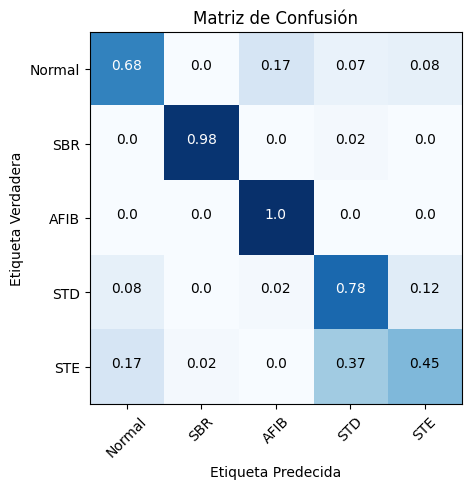

In [21]:
# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\NA\\'
ModelGRU_best = keras.models.load_model(model_file+'mejor_modelo_RNN_NA.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelGRU_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NA\\\MatrizDatosTestMejorModeloEntrenadoNA.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [22]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NA\\'
with open(path+'historial_Modelo_RNN_NA_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelGRU.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NA\\Modelo_RNN_NA_final.h5')
ModelGRU_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NA\\Modelo_RNN_NA_Best_final.h5')

In [25]:
datos={
    'f1':[0.6251,0.9016,0.9568,0.9748,0.9844,0.9862,0.9878,0.9875,0.9907,0.9913,0.9929,0.9949,0.9931,0.9935,0.9945,0.9958,0.9942,0.9947,0.9937,0.9933,0.9955,0.9958,0.9964,0.9972,0.9968,0.9955,0.9960,0.9965,0.9961,0.9944],
    'accuracy':[0.6386,0.8990,0.9571,0.9748,0.9845,0.9862,0.9878,0.9878,0.9911,0.9915,0.9929,0.9947,0.9929,0.9936,0.9941,0.9958,0.9940,0.9947,0.9934,0.9933,0.9955,0.9958,0.9963,0.9973,0.9966,0.9956,0.9960,0.9965,0.9961,0.9946],
    'auc':[0.8678,0.9882,0.9972,0.9986,0.9993,0.9993,0.9994,0.9995,0.9998,0.9996,0.9996,0.9999,0.9998,0.9999,0.9997,1.0000,0.9999,0.9999,0.9998,0.9997,0.9997,0.9999,1.0000,0.9999,0.9998,1.0000,0.9999,0.9999,0.9999,0.9995],
    'val_f1':[0.0000,0.0000,0.0000,0.0000,0.0123,0.3748,0.4420,0.4632,0.3704,0.4196,0.4436,0.4347,0.3846,0.5071,0.6391,0.7280,0.5237,0.6422,0.4803,0.5324,0.5332,0.6161,0.6328,0.7415,0.8253,0.7896,0.8290,0.6396,0.6555,0.6731],
    'val_accuracy':[0.2000,0.2000,0.2000,0.3633,0.3300,0.3233,0.3367,0.3667,0.3467,0.3500,0.3667,0.3800,0.3767,0.4633,0.5100,0.6533,0.6133,0.7433,0.6200,0.6333,0.6833,0.7133,0.7133,0.7767,0.7833,0.7433,0.8167,0.7400,0.7300,0.7433],
    'val_auc':[0.5609,0.5533,0.5778,0.6216,0.6069,0.6046,0.6481,0.6723,0.6628,0.6824,0.7264,0.7475,0.7868,0.8078,0.8069,0.8944,0.8818,0.9063,0.8631,0.8342,0.8746,0.8709,0.9055,0.9090,0.9160,0.9038,0.9237,0.8992,0.8599,0.8896]
}

In [26]:
import numpy as np
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 81.67
accuracy: 99.72999999999999
val_f1: 82.89999999999999
f1: 99.72
val_auc: 92.36999999999999
auc: 100.0


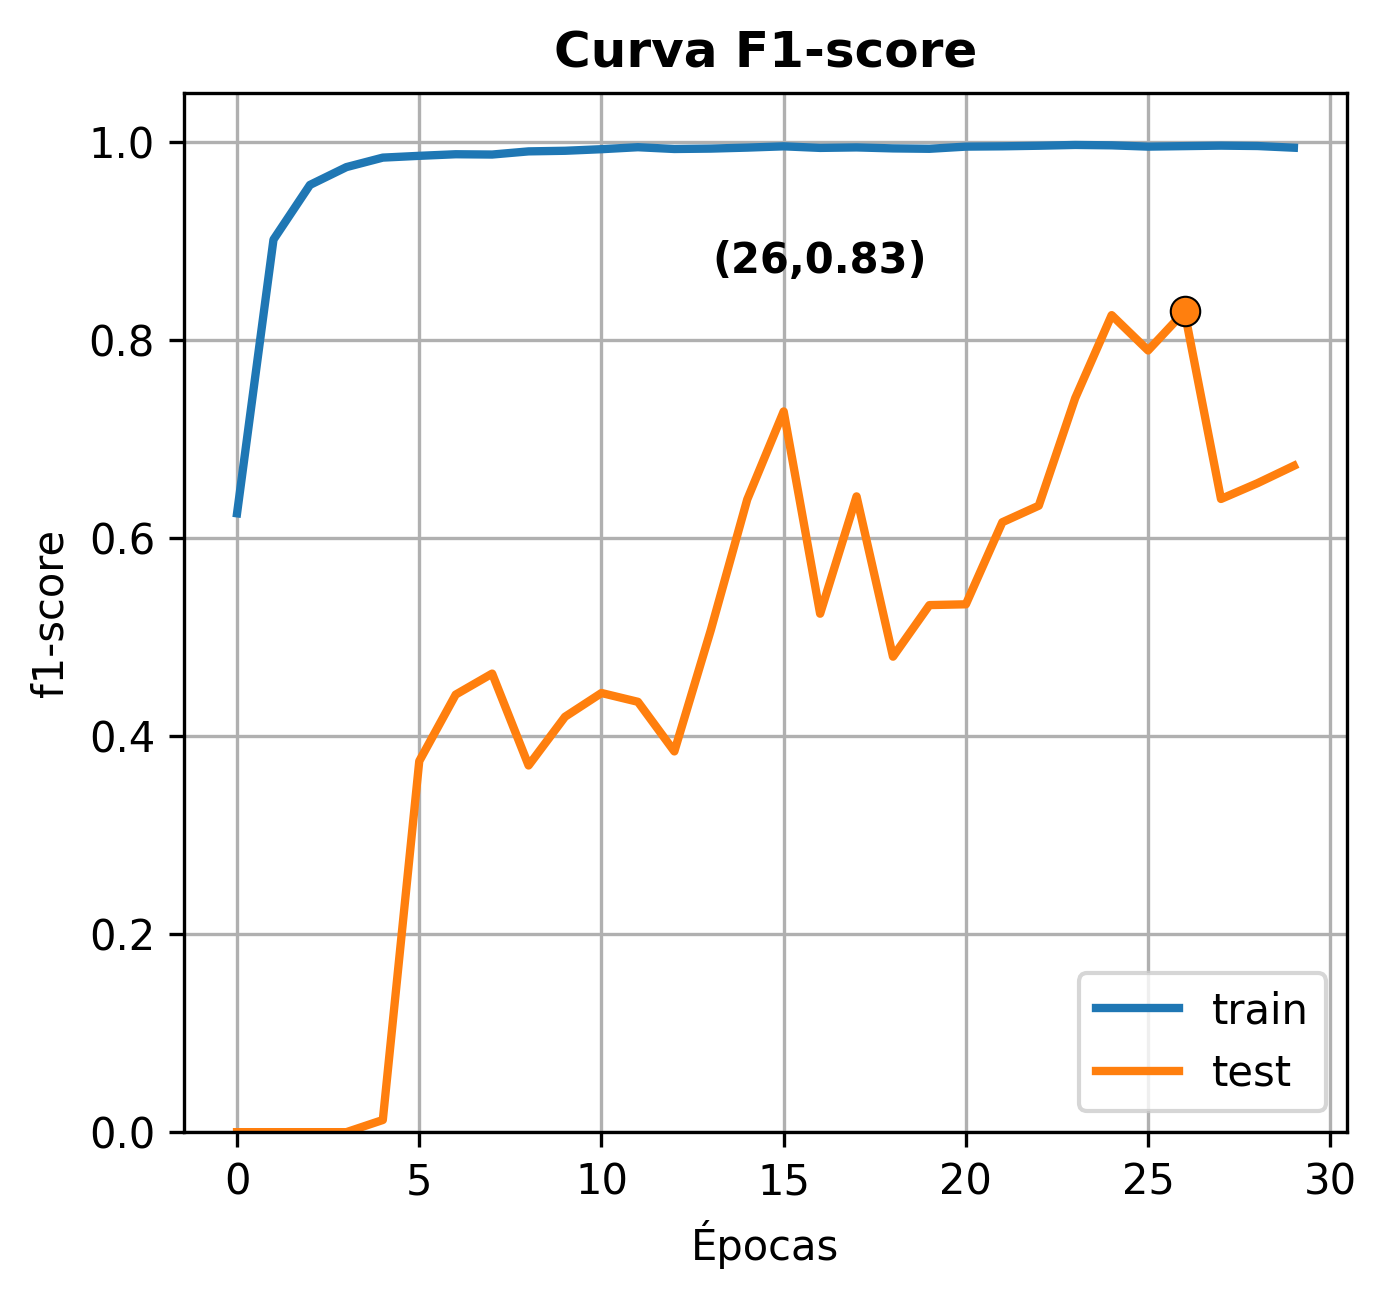

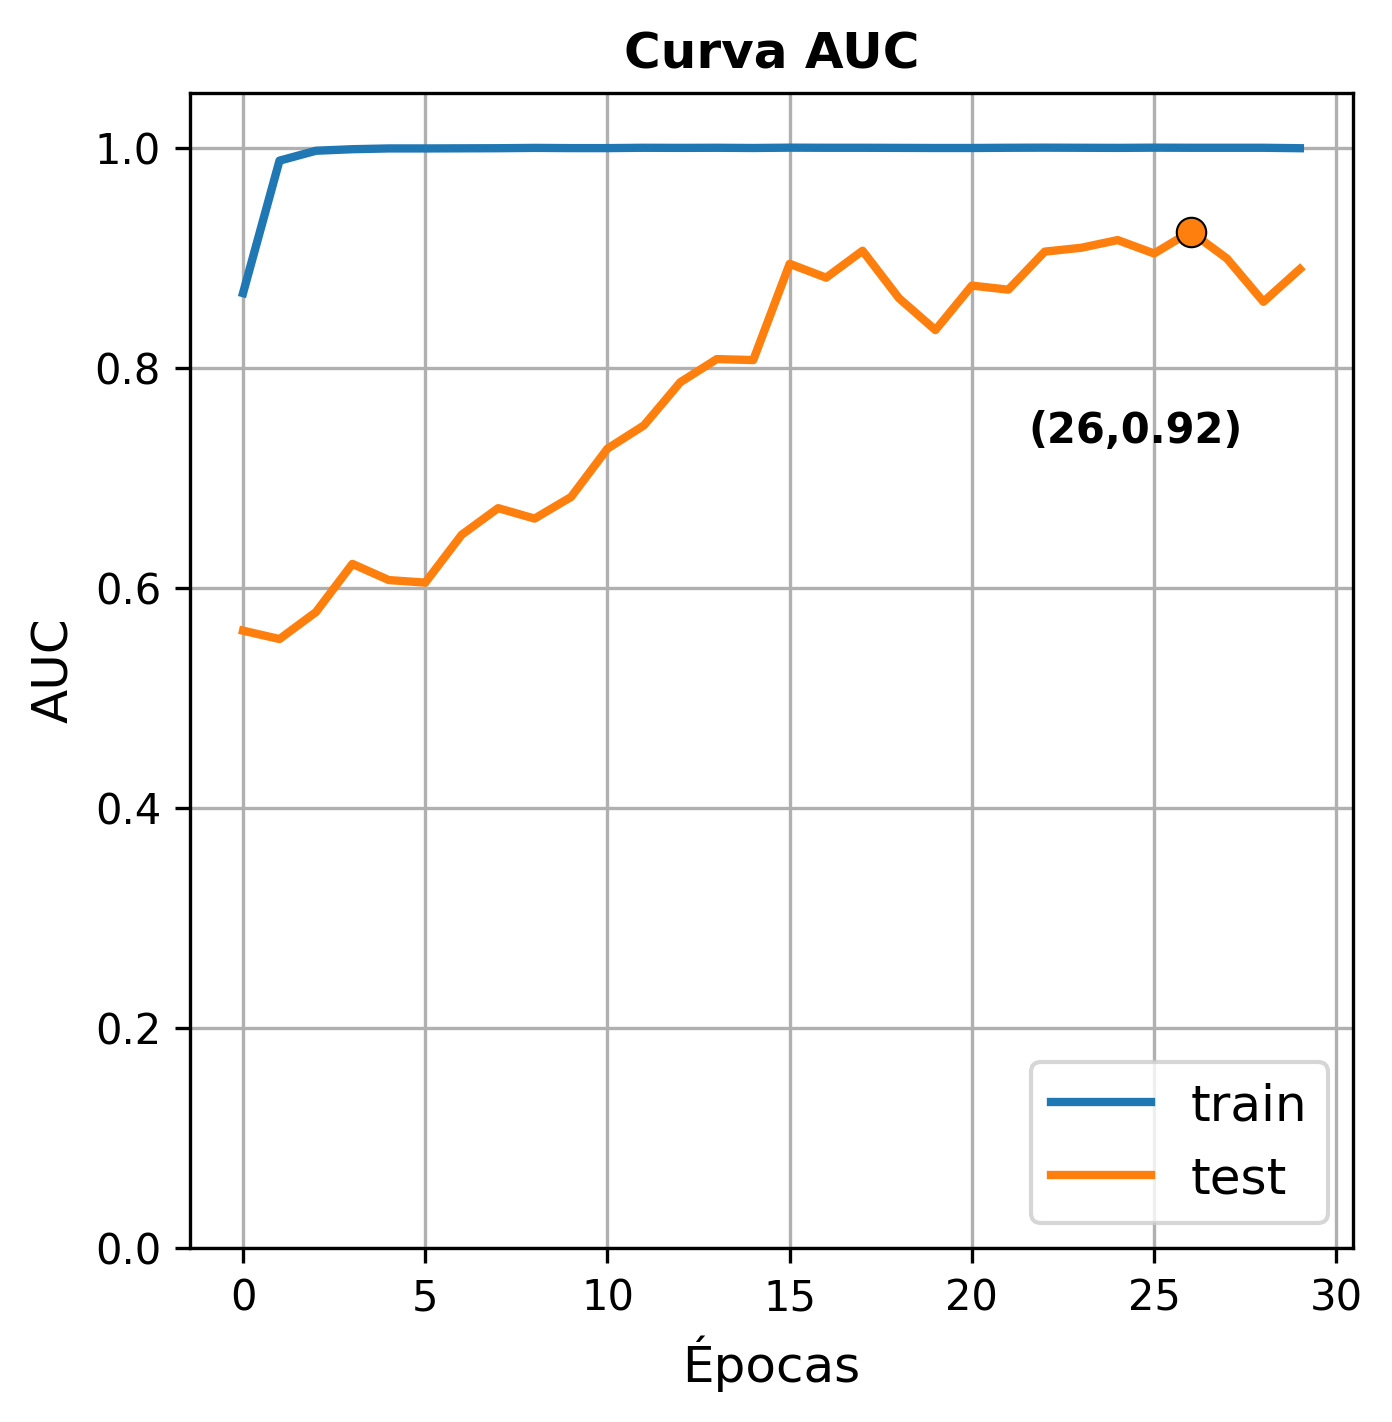

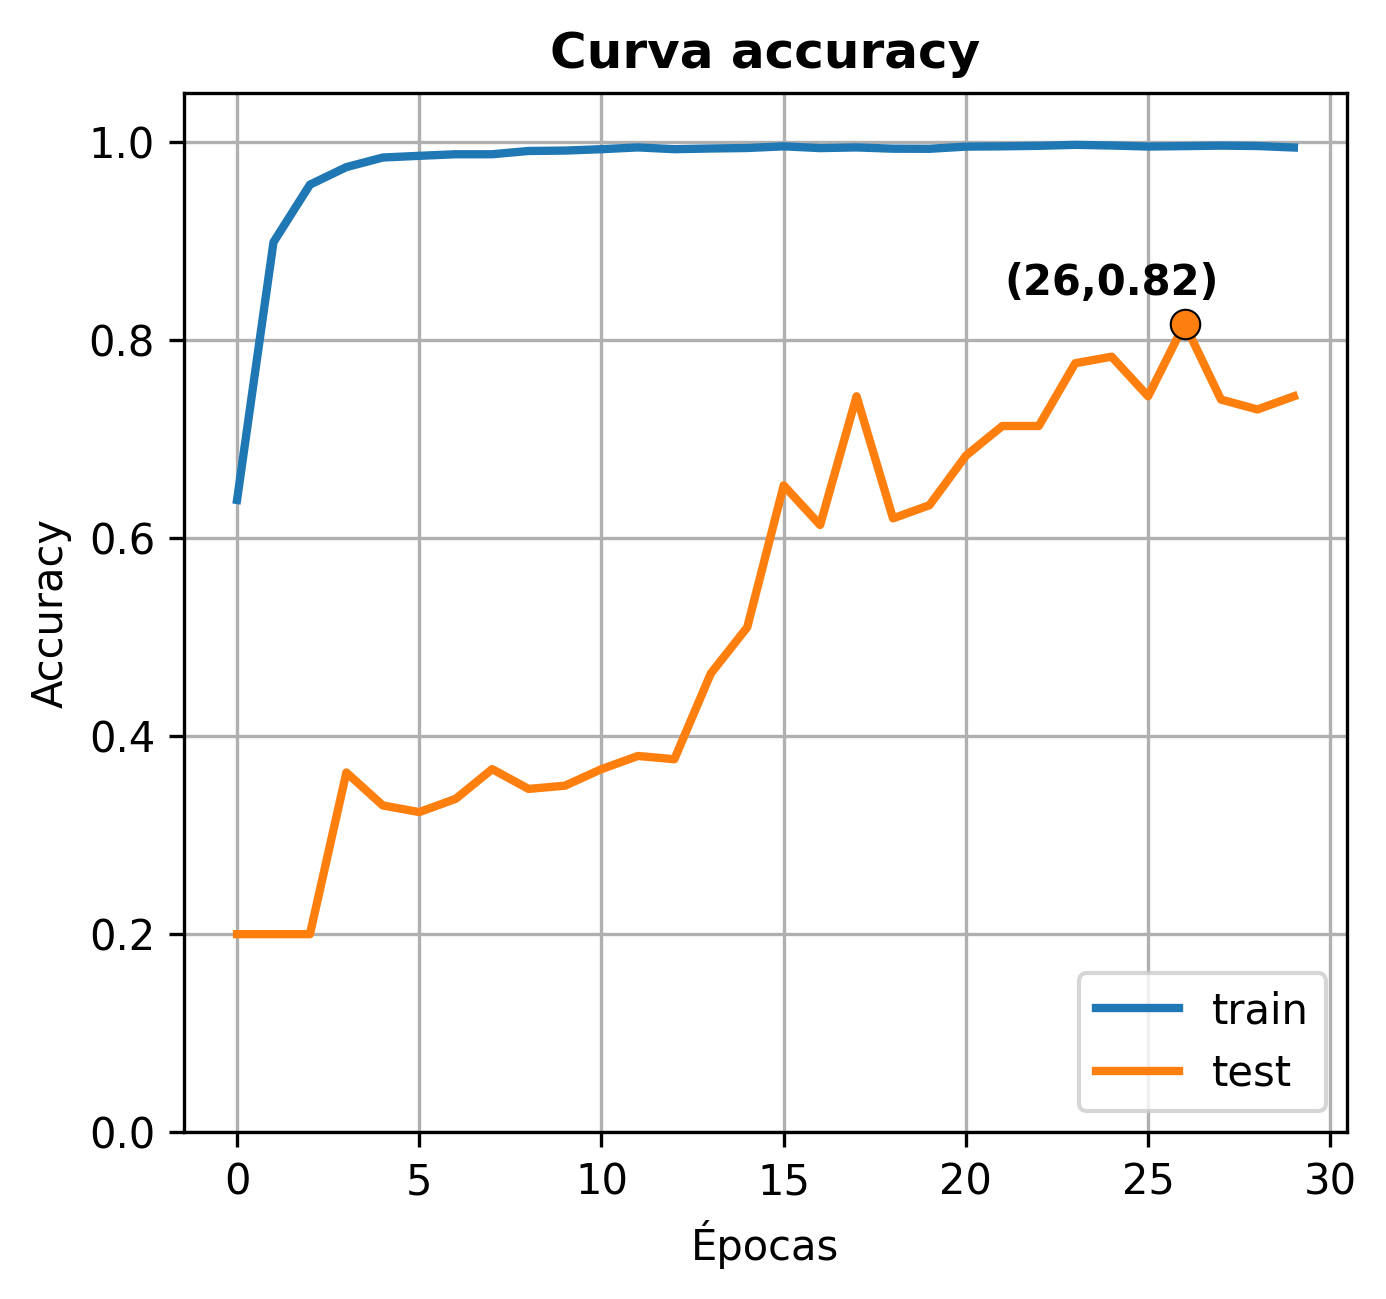

In [17]:
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-10, y_max+0.03, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NA\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-1.5, y_max-0.2, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NA\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2, y_max+0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NA\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()